# Applied Machine Learning Project:
## Topic Modeling to cluster niche book subgenres

### Members: Srijeeta Biswas, Priyana Aragula, Angky William

In [109]:
# installing libraries
# !pip uninstall umap --yes
# !pip install umap-learn

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
# import umap
import umap.umap_ as umap
from collections import defaultdict

from scipy import linalg, spatial
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
from sklearn.feature_extraction.text import (CountVectorizer, TfidfTransformer, TfidfVectorizer)

from sklearn.utils.extmath import randomized_svd

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [2]:
# importing csv and converting to df
def create_df(filepath):
    df_all_books = pd.read_json(
        filepath,
        lines=True
    )
    # print(df_all_books.head(3))
    return pd.DataFrame(df_all_books[['title','description']])

In [3]:
def missing_vals(df):
    """
    Outputs missing values in dataframe & removes observations with missing values.
    Input:
    Output:
    """
    print(df.isna().sum())
    # removing rows
    df_clean = df.dropna()
    return df_clean

In [4]:
# setting stop words
stop_words = set(stopwords.words('english'))

def tokenize(corpus):
    """
    Function will split whole document into individual words using a tokenizer.
    Input: Corpus of documents to tokenize.
    Output: Dictionary containing filtered text.
    """
    filtered_text = []
    
    for doc in corpus:
        try:
            
            clean_doc = ' '.join(re.sub(r"[^A-Za-z \—]+", " ", doc).split())
            # lower casing
            clean_doc = clean_doc.lower()
            # tokenization
            doc_tokens = word_tokenize(clean_doc)
            # removing stop words
            filtered_doc = [word for word in doc_tokens if word not in stop_words]
            # stemming words
            stemmer = PorterStemmer()
            filtered_doc = [stemmer.stem(word) for word in filtered_doc]
            
            filtered_text.append(' '.join(filtered_doc))
        except Exception as e:
            print(f'Error: {e}', doc)

    return filtered_text

In [5]:
def word_freq(filtered_text):
    """
    Form word frequency matrix to count usage of different words in corpus.
    Input:
    Output:
    """
    vectorizer = CountVectorizer()
    mat = vectorizer.fit_transform(filtered_text)
    feature_names = vectorizer.get_feature_names_out()

    mat_df = pd.DataFrame(mat.toarray(), columns = feature_names)
    mat_df.index = ["Document " + str(i+1) for i in range(len(filtered_text))]
    return mat_df, feature_names

In [6]:
def Kmeans(X):
    """
    Outputs visualization of clusters using KMeans algorithm. Purely for plotting.
    Input:
    Output:
    """
    num_clusters = 10
    km = KMeans(n_clusters = num_clusters)
    km.fit(X)
    clusters = km.labels_.tolist()
    unique_clusters = np.unique(clusters)
    return clusters

In [7]:
def topic_modeling_LSA(X, terms, n_components=10, n_iter=100):
    """
    Represents each term and doc as a vector. Decompose into multiple matrices using doc-term matrix. Here we will apply LSA.
    Input:
    Output:
    """
    U, sigma, VT = randomized_svd(
        X, n_components=n_components, n_iter=n_iter, random_state=50
    )

    for i, c in enumerate(VT):
        terms_c = zip(terms, c)
        sorted_terms = sorted(terms_c, key=lambda x:x[1],
                              reverse=True)[:7]
        print("Subgenre Concept " + str(i) + ": ")
        for t in sorted_terms:
            print(t[0])
        print(' ')
    return U, sigma, VT

In [8]:
def visualize(U, sigma, clusters):
    X_topics = U*sigma
    embedding = umap.UMAP(n_neighbors=100, min_dist=0.5,
    random_state=19).fit_transform(X_topics)

    plt.figure(figsize=(7,5))
    plt.scatter(embedding[:, 0], embedding[:, 1], 
    c = clusters,
    s = 10, # size
    edgecolor='none'
    )
    plt.show()

----------

In [9]:
# only first 15 pages
df15 = create_df(
    '/Users/angky/Cornell/AML/AML-Project/book_best_books_001_015.jl'
)
print(df15.head(10))
df15.shape # ~1500 books in dataset

                         title  \
0             The Hunger Games   
1  Jonathan Livingston Seagull   
2            Lord of the Flies   
3             Romeo and Juliet   
4                     Stardust   
5                 Tao Te Ching   
6  The Hunchback of Notre-Dame   
7      The Things They Carried   
8        Because of Winn-Dixie   
9    Midnight Sun [2008 Draft]   

                                         description  
0  Could you survive on your own in the wild, wit...  
1  This is a story for people who follow their he...  
2  At the dawn of the next world war, a plane cra...  
3  In Romeo and Juliet, Shakespeare creates a vio...  
4  Alternate cover edition can be found hereYoung...  
5  A lucid translation of the well-known Taoist c...  
6  This extraordinary historical French gothic no...  
7  A classic work of American literature that has...  
8  The summer Opal and her father, the preacher, ...  
9  The record for the completed novel can be foun...  


(1500, 2)

In [10]:
df15 = missing_vals(df15)
df15

title          1
description    2
dtype: int64


,title,description
0,The Hunger Games,"Could you survive on your own in the wild, wit..."
1,Jonathan Livingston Seagull,This is a story for people who follow their he...
2,Lord of the Flies,"At the dawn of the next world war, a plane cra..."
3,Romeo and Juliet,"In Romeo and Juliet, Shakespeare creates a vio..."
4,Stardust,Alternate cover edition can be found hereYoung...
...,...,...
1495,To Kill a Mockingbird,The unforgettable novel of a childhood in a sl...
1496,The Book Thief,Librarian's note: An alternate cover edition c...
1497,Pride and Prejudice,"Since its immediate success in 1813, Pride and..."
1498,Harry Potter and the Order of the Phoenix,Harry Potter is about to start his fifth year ...


In [11]:
filtered_text = tokenize(df15['description'].to_numpy())
filtered_text

['could surviv wild everi one make sure live see morn ruin place known north america lie nation panem shine capitol surround twelv outli district capitol harsh cruel keep district line forc send one boy one girl age twelv eighteen particip annual hunger game fight death live tv sixteen year old katniss everdeen live alon mother younger sister regard death sentenc step forward take sister place game katniss close dead before—and surviv second natur without realli mean becom contend win start make choic weight surviv human life love',
 'stori peopl follow heart make rule peopl get special pleasur someth well even peopl know live meet eye right jonathan fli higher faster ever dream jonathan livingston seagul ordinari bird believ everi gull right fli reach ultim freedom challeng discoveri find greatest reward teach younger gull joy flight power dream special th anniversari releas spiritu classic',
 'dawn next world war plane crash unchart island strand group schoolboy first adult supervis 

In [32]:
word_freq_mat, feature_names = word_freq(filtered_text)
word_freq_mat

,aaron,ab,ababa,aback,abandon,abbey,abbi,abbot,abbott,abduct,...,zugegebenerma,zulassen,zulu,zum,zumindest,zur,zusak,zwerg,zwischen,zylska
Document 1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Document 2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Document 3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Document 4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Document 5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Document 1494,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Document 1495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
Document 1496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Document 1497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans

# Number of topics
n_topics = 5

# Number of clusters
n_clusters = 5

# Assume word_freq_mat is your DataFrame and its values are word frequencies
# Convert DataFrame to a matrix if it's not already
word_freq_matrix = word_freq_mat.values

# Fit LDA model
lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
lda_topic_matrix = lda.fit_transform(word_freq_matrix)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(lda_topic_matrix)

# Predict the cluster for each document
clusters = kmeans.predict(lda_topic_matrix)

# Add cluster information back to the original DataFrame
word_freq_mat['cluster'] = clusters

# Display the first few rows of the DataFrame
print(word_freq_mat.head())


/Users/angky/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


            aaron  ab  ababa  aback  abandon  abbey  abbi  abbot  abbott  \
Document 1      0   0      0      0        0      0     0      0       0   
Document 2      0   0      0      0        0      0     0      0       0   
Document 3      0   0      0      0        0      0     0      0       0   
Document 4      0   0      0      0        0      0     0      0       0   
Document 5      0   0      0      0        0      0     0      0       0   

            abduct  ...  zugegebenerma  zulassen  zulu  zum  zumindest  zur  \
Document 1       0  ...              0         0     0    0          0    0   
Document 2       0  ...              0         0     0    0          0    0   
Document 3       0  ...              0         0     0    0          0    0   
Document 4       0  ...              0         0     0    0          0    0   
Document 5       0  ...              0         0     0    0          0    0   

            zusak  zwerg  zwischen  zylska  
Document 1      0      

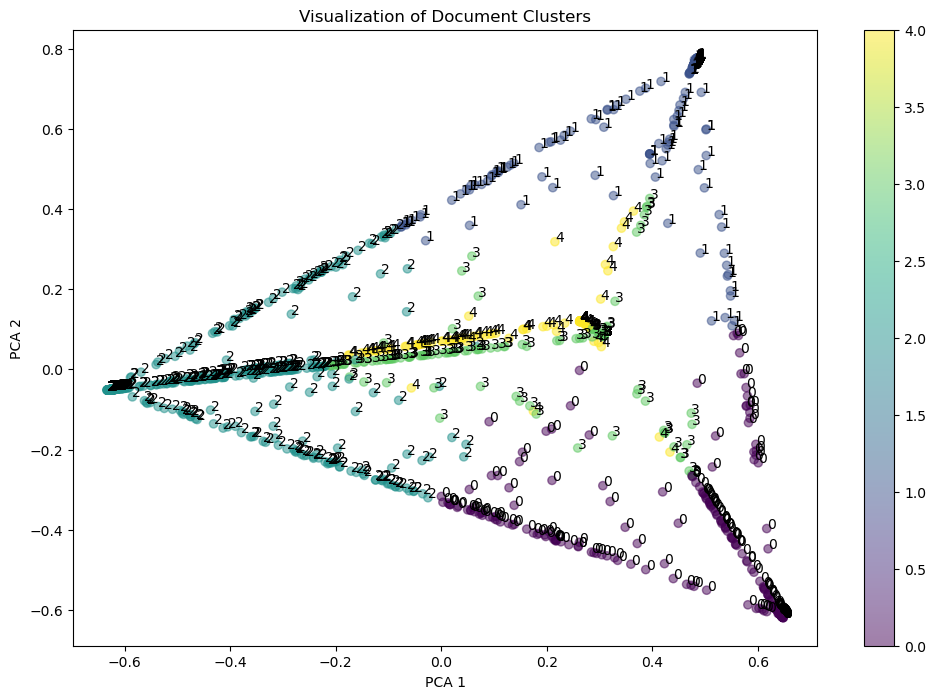

In [35]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Let's assume lda_topic_matrix contains your LDA topic distribution and
# clusters contains the KMeans cluster assignments

# Reduce the dimensionality for visualization (using PCA for simplicity)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(lda_topic_matrix)

# Scatter plot of the reduced data
plt.figure(figsize=(12, 8))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', alpha=0.5)

# Add labels to the plot with cluster numbers
for i, txt in enumerate(clusters):
    plt.annotate(txt, (reduced_data[i, 0], reduced_data[i, 1]))

plt.title('Visualization of Document Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(scatter)
plt.show()


In [15]:
# labels clustering each doc into clusters 1-10
labels = Kmeans(word_freq_mat)
labels

/Users/angky/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[5,
 9,
 9,
 9,
 9,
 5,
 9,
 9,
 5,
 9,
 9,
 9,
 9,
 9,
 9,
 5,
 5,
 9,
 5,
 5,
 5,
 9,
 9,
 9,
 9,
 9,
 5,
 5,
 9,
 9,
 9,
 5,
 9,
 5,
 9,
 9,
 5,
 9,
 5,
 9,
 5,
 9,
 9,
 9,
 5,
 9,
 9,
 5,
 9,
 5,
 5,
 9,
 9,
 5,
 5,
 5,
 9,
 9,
 9,
 5,
 9,
 5,
 5,
 9,
 5,
 9,
 5,
 5,
 9,
 9,
 9,
 9,
 9,
 6,
 5,
 9,
 9,
 9,
 9,
 9,
 5,
 9,
 9,
 9,
 5,
 5,
 9,
 9,
 9,
 9,
 9,
 5,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 5,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 5,
 9,
 9,
 5,
 9,
 9,
 9,
 5,
 9,
 5,
 9,
 9,
 9,
 5,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 5,
 5,
 9,
 9,
 9,
 5,
 5,
 9,
 9,
 9,
 9,
 9,
 9,
 5,
 5,
 9,
 5,
 9,
 9,
 5,
 5,
 6,
 5,
 9,
 9,
 9,
 9,
 5,
 9,
 5,
 5,
 9,
 9,
 9,
 5,
 9,
 9,
 9,
 9,
 9,
 5,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 5,
 5,
 5,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 5,
 5,
 5,
 9,
 5,
 5,
 9,
 9,
 9,
 9,
 9,
 5,
 9,
 5,
 5,
 5,
 9,
 9,
 9,
 9,
 5,
 9,
 9,
 9,
 5,
 9,
 9,
 9,
 9,
 9,
 5,
 5,
 5,
 5,
 9,
 5,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 5,
 9,
 9,
 9,
 9,
 9,
 9,


In [16]:
U, sigma, VT = topic_modeling_LSA(word_freq_mat, feature_names)


Subgenre Concept 0: 
one
life
love
world
stori
new
live
 
Subgenre Concept 1: 
stori
adventur
book
novel
edit
reader
classic
 
Subgenre Concept 2: 
adventur
one
three
holm
sherlock
world
man
 
Subgenre Concept 3: 
love
adventur
life
live
famili
hous
laura
 
Subgenre Concept 4: 
one
stori
love
boy
littl
adam
live
 
Subgenre Concept 5: 
de
la
le
un
one
se
et
 
Subgenre Concept 6: 
book
life
live
littl
one
hous
laura
 
Subgenre Concept 7: 
new
novel
edit
love
first
time
famili
 
Subgenre Concept 8: 
stori
year
ss
famili
littl
hous
laura
 
Subgenre Concept 9: 
book
love
stori
read
littl
tale
find
 


In [29]:
print(VT.shape)
print(feature_names.shape)

for i, c in enumerate(VT):
    print(c.shape)
    terms_c = zip(feature_names, c)

(10, 14402)
(14402,)
(14402,)
(14402,)
(14402,)
(14402,)
(14402,)
(14402,)
(14402,)
(14402,)
(14402,)
(14402,)


/Users/srijeetabiswas/.conda/envs/myenv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


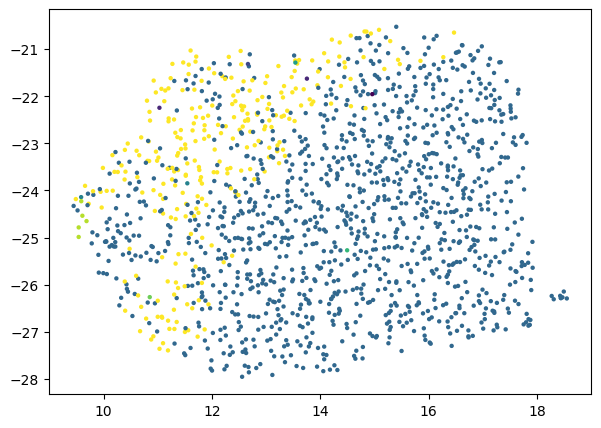

In [124]:
visualize(U, sigma, labels)

In [125]:
df15['label'] = labels
u_labels = np.unique(labels)
clustered_books = defaultdict(list)

for u in u_labels:
    # print('Cluster ' + str(u))
    clustered_books[u] = df15[df15['label'] == u]['title'].to_numpy()
clustered_books

defaultdict(list,
            {0: array(['The Canterbury Tales'], dtype=object),
             1: array(['The Rescue', 'The Illustrated Man'], dtype=object),
             2: array(['The Thorn Birds'], dtype=object),
             3: array(['Jonathan Livingston Seagull', 'Lord of the Flies',
                    'Romeo and Juliet', ..., 'Pride and Prejudice',
                    'Harry Potter and the Order of the Phoenix', 'Pretty Little Liars'],
                   dtype=object),
             4: array(['Life, the Universe and Everything',
                    "The Ultimate Hitchhiker's Guide to the Galaxy"], dtype=object),
             5: array(['Interview with the Vampire'], dtype=object),
             6: array(['The Complete Sherlock Holmes'], dtype=object),
             7: array(['Dreamfever'], dtype=object),
             8: array(['The Lord of the Rings', 'The Two Towers',
                    'The Fellowship of the Ring', 'And Then There Were None',
                    'The Fellowship o